# TPC based Cosmic Rate measurement
This notebook does only use the event/pfp trees

## Imports

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import uproot
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import helpfunction as helper

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
pd.options.display.max_columns = 999
muon_mass = 0.105658

<IPython.core.display.Javascript object>

## Constants

In [4]:
main_tree_name = "cosmicstudies"

# Input files
file_name_mc_sce = "./input/corsika_p_sce_30k.root"
file_name_mc_ddsce = "./input/corsika_p_ddsce_8k.root"
file_name_mc_nosce = "./input/corsika_p_nosce_6k.root"
file_name_mc_cmc = "./input/corsika_cmc_sce_8k.root"
file_name_mc_con16 = "./input/corsika_p_ddsce_con16_10k.root"
file_name_mc_con30 = "./input/corsika_p_ddsce_con30_10k.root"

file_name_data1 = "./input/extunbiased_run1.root"
file_name_data3 = "./input/CosmicStudiesCRT_run3_48k_mcc9.root"

outdir = "./Output/Paper/"

good_start = -0.4e6  # Start of MC time where we are not biased by out of time charge
good_end = 0.4e6  # End of good MC time window (in ns)
t_begin = good_start / 1e6
t_end = good_end / 1e6

per1 = 50 - 45  # 68.27/2            # 1sigma stat boundaries
per2 = 50 + 45  # 68.27/2
per21 = 50 - 95.45 / 2
per22 = 50 + 95.45 / 2
persig1 = 50 - 68.27 / 2
persig2 = 50 + 68.27 / 2

ub_tag = "MicroBooNE Data"

<IPython.core.display.Javascript object>

In [5]:
zenith_ticks = [0, np.pi / 8, np.pi / 4, 3 * np.pi / 8, np.pi / 2]
zenith_labels = [r"$0$", r"$\pi/8$", r"$\pi/4$", r"$3\pi/8$", r"$\pi$/2"]

azimuth_ticks = [
    -np.pi,
    -3 * np.pi / 4,
    -np.pi / 2,
    -np.pi / 4,
    0,
    np.pi / 4,
    np.pi / 2,
    3 * np.pi / 4,
    np.pi,
]
azimuth_labels = [
    r"$-\pi$",
    r"$-3\pi/4$",
    r"$-\pi/2$",
    r"$-\pi/4$",
    "0",
    r"$\pi/4$",
    r"$\pi/2$",
    r"$3\pi/4$",
    r"$\pi$",
]

<IPython.core.display.Javascript object>

In [6]:
mc_keys = ["sce", "ddsce", "nosce", "cmc", "reduced LArTF", "increased LArTF"]
mc_file_names = [
    file_name_mc_sce,
    file_name_mc_ddsce,
    file_name_mc_nosce,
    file_name_mc_cmc,
    file_name_mc_con16,
    file_name_mc_con30,
]
mc_files = [uproot.open(f)[main_tree_name] for f in mc_file_names]
mc_labs = [
    "CORSIKA, simulated space charge    ",
    "CORSIKA, data-driven space charge  ",
    "CORSIKA, without space charge      ",
    "CORSIKA+CMC, simulated space charge",
    "CORSIKA, reduced LArTF building",
    "CORSIKA, increased LArTF building",
]

data_file = uproot.open(file_name_data1)[main_tree_name]
data_lab = "Cosmic Data"  # (Run 1)"

<IPython.core.display.Javascript object>

## Functions

In [7]:
def cosmic_angles(mom_x, mom_y, mom_z, df_out=True):
    mask_flip_dir = (mom_y > 0) * 2 - 1
    mom_x, mom_y, mom_z = (
        mask_flip_dir * mom_x,
        mask_flip_dir * mom_y,
        mask_flip_dir * mom_z,
    )

    theta_cosmic = np.arctan2(np.sqrt(np.square(mom_x) + np.square(mom_z)), mom_y)
    phi_cosmic = np.arctan2(mom_x, mom_z)
    if df_out:
        return pd.DataFrame({"zenith": theta_cosmic, "azimuth": phi_cosmic})[
            ["zenith", "azimuth"]
        ]
    else:
        return np.array([theta_cosmic, phi_cosmic])

<IPython.core.display.Javascript object>

In [8]:
def straight_length(x_s, y_s, z_s, x_e, y_e, z_e):
    return np.sqrt((x_s - x_e) ** 2 + (y_s - y_e) ** 2 + (z_s - z_e) ** 2)

<IPython.core.display.Javascript object>

In [9]:
def cosmic_angles_start_end(x_s, y_s, z_s, x_e, y_e, z_e, df_out=True):
    return cosmic_angles(x_s - x_e, y_s - y_e, z_s - z_e, df_out)

<IPython.core.display.Javascript object>

In [10]:
# should return resolution per bin
def getResolution(data_x, data_y, x_edges, ax, periodic=False):
    mean = []
    err = []
    percentiles_arr = []

    mids = 0.5 * (x_edges[1:] + x_edges[:-1])
    bin_id = np.digitize(data_x, x_edges)
    data_diff = data_y - data_x
    if periodic:
        data_diff = (data_diff + np.pi) % (2 * np.pi) - np.pi
        data_diff *= 180 / np.pi
        mids *= 180 / np.pi
    for i in range(1, len(x_edges)):
        ax.hist(
            data_diff[bin_id == i],
            bins=50,
            range=np.percentile(data_diff, [per21, per22]),
            histtype="step",
        )
        percentiles = np.percentile(
            data_diff[bin_id == i], [per1, persig1, 50, persig2, per2]
        )
        print(
            round(10 * mids[i - 1]) / 10,
            "\t",
            np.median(data_y[bin_id == i]),
            "\t",
            percentiles[[1, 2, 3]],
            "\t",
            (percentiles[3] - percentiles[1]) / 2,
        )
        if periodic:
            percentiles /= 180 / np.pi
            mean.append(mids[i - 1] / (180 / np.pi) + percentiles[2])
        else:
            mean.append(mids[i - 1] + percentiles[2])
        err.append([percentiles[2] - percentiles[1], percentiles[3] - percentiles[2]])
        percentiles_arr.append(percentiles)
    if periodic:
        mids /= 180 / np.pi
    quants = np.array(percentiles_arr).T
    return mids, mean, err, quants

<IPython.core.display.Javascript object>

## Queries

In [11]:
clean_query = "(pfp_length_traj>25)"
primary_matched_query = "(track_matched_process==23)"
muon_matched_query = "(track_matched_pdgcode==13 | track_matched_pdgcode==-13)"
intpc_matched_query = "(track_matched_length_tpc>0)"

matched_query = (
    primary_matched_query + " & " + muon_matched_query + " & " + intpc_matched_query
)
clean_muon_query = clean_query + "&" + matched_query

<IPython.core.display.Javascript object>

## Load the data

Event numbers and scales

In [12]:
data_n = data_file["Event"].numentries
print("%s \tEvents: %d\n" % (data_lab, data_n))

mc_n = []
mc_scales = []

for l, f in zip(mc_labs, mc_files):
    mc_n.append(f["Event"].numentries)
    mc_scales.append(data_n / mc_n[-1])
    print("%s \tEvents: %d \tScale: {0:0.2f}".format(mc_scales[-1]) % (l, mc_n[-1]))

Cosmic Data 	Events: 22405

CORSIKA, simulated space charge     	Events: 29800 	Scale: 0.75
CORSIKA, data-driven space charge   	Events: 7880 	Scale: 2.84
CORSIKA, without space charge       	Events: 6200 	Scale: 3.61
CORSIKA+CMC, simulated space charge 	Events: 8160 	Scale: 2.75
CORSIKA, reduced LArTF building 	Events: 9774 	Scale: 2.29
CORSIKA, increased LArTF building 	Events: 9751 	Scale: 2.30


<IPython.core.display.Javascript object>

In [13]:
# Load pfp df
mc_pfp = [f["PFParticles"].pandas.df() for f, s in zip(mc_files, mc_scales)]
data_pfp = data_file[b"PFParticles"].pandas.df()
print(len(mc_pfp[0]))
print(len(mc_pfp[1]))
print(len(data_pfp))

536438
142412
423852


<IPython.core.display.Javascript object>

In [14]:
mc_pfp[1].head()

,event,run,subrun,num_pfp,num_mcp,num_mcp_saved,num_flashes,pdg_code,num_daughters,is_primary,n_hits,n_clusters,pfp_vx,pfp_vy,pfp_vz,track_valid,track_startx,track_starty,track_startz,track_endx,track_endy,track_endz,track_length,track_hasmomentum,track_startmomentumx,track_startmomentumy,track_startmomentumz,track_endmomentumx,track_endmomentumy,track_endmomentumz,track_theta,track_phi,track_zenith,track_azimuth,track_mcs_momentum,track_mcs_mom_err,track_mcs_likelihood,track_mcs_energy,track_matched_pdgcode,track_matched_energy,track_matched_kBeamNeutrino,track_matched_time,track_matched_process,track_matched_end_process,track_matched_startinside,track_matched_endinside,track_matched_partinside,track_matched_startx,track_matched_starty,track_matched_startz,track_matched_endx,track_matched_endy,track_matched_endz,track_matched_startx_sce,track_matched_starty_sce,track_matched_startz_sce,track_matched_endx_sce,track_matched_endy_sce,track_matched_endz_sce,track_matched_length_tpc,track_matched_length_sce,track_matched_startmomentumx,track_matched_startmomentumy,track_matched_startmomentumz
entry,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2381,1,120,105,20347,212,0,13,6,True,2060,3,41.830238,114.789833,671.741882,True,41.830238,114.789833,671.741882,102.457611,-109.783791,956.352661,367.691803,False,0.172579,-0.625107,0.761221,0.156831,-0.636631,0.755053,0.705602,-1.301428,0.895528,0.222944,1.54,0.18,104.816666,1.437962,13,11.079523,False,-8.318029e+05,23,24,False,False,True,131.381622,117.470001,671.638550,190.924118,-115.529999,957.175720,39.456417,110.682899,671.574463,99.639656,-105.502434,956.874817,373.317261,362.929535,1.686913,-6.914351,8.490627
1,2381,1,120,105,20347,212,0,13,3,True,1552,3,128.765442,117.042770,895.557617,True,128.765442,117.042770,895.557617,125.140106,-115.539772,962.420044,242.174225,False,-0.015854,-0.977882,0.208557,0.010635,-0.947313,0.320133,1.360697,-1.587007,0.210715,-0.075871,0.83,0.10,77.975319,0.731040,13,2.913286,False,1.066860e+06,23,25,False,False,True,9.116932,117.470001,895.579285,5.522072,-115.529999,962.262329,130.480637,117.379021,895.485107,126.825783,-115.503937,962.170044,242.380997,242.244003,-0.042013,-2.809682,0.761572
2,2381,1,120,105,20347,212,0,13,6,True,1426,3,209.283264,100.415970,918.218384,True,209.283264,100.415970,918.218384,86.913269,-110.384628,825.118286,260.963287,False,-0.475469,-0.815586,-0.329771,-0.417333,-0.840456,-0.345640,1.906858,-2.098606,0.617056,-2.177194,1.29,0.17,70.631271,1.188662,13,2.514027,False,-4.474533e+05,23,25,False,False,True,254.800003,110.712105,919.253052,133.376221,-115.529999,825.090820,207.709091,96.990128,918.813843,84.884758,-108.678734,825.047791,273.488098,257.410431,-1.106491,-2.083087,-0.863477
3,2381,1,120,105,20347,212,0,13,6,True,1422,3,48.801167,95.887886,701.340515,True,48.801167,95.887886,701.340515,-44.725033,-14.390596,532.453979,222.415298,False,-0.486829,-0.557819,-0.672187,-0.429114,-0.475901,-0.767711,2.307955,-2.288343,0.979040,-2.514779,0.89,0.12,66.950012,0.790592,-13,6.897392,False,-1.722486e+06,23,25,False,False,True,244.803864,117.470001,721.047363,55.112148,-115.529999,382.362427,53.104519,101.160072,720.946289,-138.291458,-114.216309,382.454956,452.746552,444.594452,-2.782687,-3.507833,-5.245437
4,2381,1,120,105,20347,212,0,13,4,True,1288,3,158.206207,37.203110,648.945496,True,158.206207,37.203110,648.945496,-28.404139,-115.058197,668.016541,241.658417,False,-0.791141,-0.605063,0.089417,-0.747718,-0.660425,0.068970,1.481260,-2.488688,0.920951,-1.458251,1.36,0.22,66.270508,1.258440,-13,66.981163,False,-9.095386e+05,23,24,False,False,True,254.800003,41.493233,648.903442,71.038788,-115.529999,668.108459,155.727509,37.207806,648.798096,-30.263672,-113.380180,668.067200,242.473312,240.076462,-50.742184,-43.416672,5.166088


<IPython.core.display.Javascript object>

In [15]:
# Add the reco zenith/azimuth angles fro reco particles based on the trajectory
for df in mc_pfp + [data_pfp]:
    cols = [
        "track_startx",
        "track_starty",
        "track_startz",
        "track_endx",
        "track_endy",
        "track_endz",
    ]
    df[["pfp_zenith_traj", "pfp_azimuth_traj"]] = cosmic_angles_start_end(
        *df[cols].T.values
    )
    df["pfp_length_traj"] = straight_length(*df[cols].T.values)

# Add the reco zenith/azimuth angles for tuth particles based on the trajectory
for df in mc_pfp:
    cols = [
        "track_matched_startx_sce",
        "track_matched_starty_sce",
        "track_matched_startz_sce",
        "track_matched_endx_sce",
        "track_matched_endy_sce",
        "track_matched_endz_sce",
    ]
    df[["mc_zenith_traj", "mc_azimuth_traj"]] = cosmic_angles_start_end(
        *df[cols].T.values
    )

<IPython.core.display.Javascript object>

In [16]:
mc_pfp[0].keys()

Index(['event', 'run', 'subrun', 'num_pfp', 'num_mcp', 'num_mcp_saved',
       'num_flashes', 'pdg_code', 'num_daughters', 'is_primary', 'n_hits',
       'n_clusters', 'pfp_vx', 'pfp_vy', 'pfp_vz', 'track_valid',
       'track_startx', 'track_starty', 'track_startz', 'track_endx',
       'track_endy', 'track_endz', 'track_length', 'track_hasmomentum',
       'track_startmomentumx', 'track_startmomentumy', 'track_startmomentumz',
       'track_endmomentumx', 'track_endmomentumy', 'track_endmomentumz',
       'track_theta', 'track_phi', 'track_zenith', 'track_azimuth',
       'track_mcs_momentum', 'track_mcs_mom_err', 'track_mcs_likelihood',
       'track_mcs_energy', 'track_matched_pdgcode', 'track_matched_energy',
       'track_matched_kBeamNeutrino', 'track_matched_time',
       'track_matched_process', 'track_matched_end_process',
       'track_matched_startinside', 'track_matched_endinside',
       'track_matched_partinside', 'track_matched_startx',
       'track_matched_starty', 't

<IPython.core.display.Javascript object>

### Verify where the non-muon tracks are coming from

In [17]:
mc_pfp[0]["track_matched_pdgcode"].value_counts() / len(mc_pfp[0])

-13      0.534492
 13      0.418952
 2112    0.016362
 22      0.015441
 2212    0.004713
-11      0.004657
 11      0.004524
 211     0.000425
-211     0.000354
-2112    0.000060
-2212    0.000011
 321     0.000006
-321     0.000004
Name: track_matched_pdgcode, dtype: float64

<IPython.core.display.Javascript object>

In [18]:
mc_pfp[0].query("abs(track_matched_pdgcode)==2112")[
    "track_matched_end_process"
].value_counts()

18     8676
17      101
999      32
Name: track_matched_end_process, dtype: int64

<IPython.core.display.Javascript object>

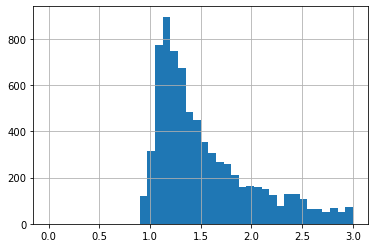

<IPython.core.display.Javascript object>

In [19]:
mc_pfp[0].query("abs(track_matched_pdgcode)==2112")["track_matched_energy"].hist(
    range=(0, 3), bins=40
)

In [20]:
# Create a bool representing the one-to-one 25+cm muon tracks:
# for resolutions, we use the p_sce frame
mc_pfp[0]["unique"] = (
    ~mc_pfp[0]
    .query(clean_query)
    .query(muon_matched_query)
    .duplicated(subset=["track_matched_time", "track_matched_energy"], keep=False)
)
print(
    "One-to-one muon matched:\t{0:0.2f}%".format(
        sum(mc_pfp[0]["unique"] == True) / len(mc_pfp[0].query(clean_query)) * 100
    )
)
print(
    "Broken muon matched:    \t{0:0.2f}%".format(
        sum(mc_pfp[0]["unique"] == False) / len(mc_pfp[0].query(clean_query)) * 100
    )
)
print(
    "Matched to another type:\t{0:0.2f}%".format(
        mc_pfp[0].query(clean_query)["unique"].isna().sum()
        / len(mc_pfp[0].query(clean_query))
        * 100
    )
)

mc_pfp[0]["time_drift_ok"] = mc_pfp[0]["track_matched_time"].between(
    good_start, good_end
)
df_resolution = mc_pfp[0].query("time_drift_ok==1 & unique==1")

One-to-one muon matched:	97.71%
Broken muon matched:    	1.32%
Matched to another type:	0.97%


<IPython.core.display.Javascript object>

In [21]:
mc_pfp[0].query(clean_query).query("unique!=unique & track_matched_pdgcode==2112")[
    "track_matched_process"
].value_counts()

23     1749
18      324
26       74
21        2
16        2
6         2
999       1
Name: track_matched_process, dtype: int64

<IPython.core.display.Javascript object>

In [ ]:
# how many muons per trigger are there? 


In [22]:
## Plots

<IPython.core.display.Javascript object>

In [23]:
mc_def = 1  # ddsce
mc_lab = "CORSIKA"
mc_scale = mc_scales[mc_def]

<IPython.core.display.Javascript object>

In [24]:
# Make a dataframe you will need later:
mc_pfp[mc_def][["mc_zenith_start", "mc_azimuth_start"]] = cosmic_angles(
    *mc_pfp[mc_def][
        [
            "track_matched_startmomentumx",
            "track_matched_startmomentumy",
            "track_matched_startmomentumz",
        ]
    ].T.values
)

df_pfp_matched_unique25 = (
    mc_pfp[mc_def]
    .query("track_length>25")
    .drop_duplicates(subset=["track_matched_time", "track_matched_energy"])
)
df_mc_muon_cross_matched_25 = df_pfp_matched_unique25.query(matched_query)

<IPython.core.display.Javascript object>

In [25]:
mc_scale

2.843274111675127

<IPython.core.display.Javascript object>

Data: 104.95+-0.22
MC: 84.78+-0.33
Data/MC: 1.238+-0.006

Data: 18.92+-0.04
MC: 18.07+-0.06
Data/MC: 1.0468+-0.0040

Data: 15.30+-0.03
MC: 15.09+-0.05
Data/MC: 1.0144+-0.0037


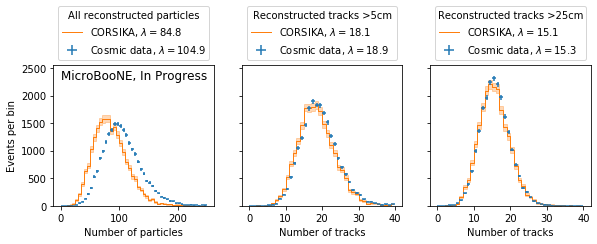

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(8.5, 3.5))

field = "num_pfp"
N = 50
x_min = 0
x_max = 250
data = [mc_files[mc_def]["Event"].array(field), data_file["Event"].array(field)]
weights = [mc_scale, 1]
edges, edges_mid, bins, err, max_y = helper.histHelper(
    N, x_min, x_max, data, weights=weights
)
means = [x.mean() for x in data]
means_err = [x.std() / np.sqrt(len(x)) for x in data]
ax[0].step(
    edges_mid,
    bins[0],
    lw=1,
    label=mc_lab + r", $\lambda=${0:.1f}".format(means[0]),
    where="mid",
    color="C1",
)
ax[0].fill_between(
    edges_mid, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step="mid", color="C1"
)
ax[0].errorbar(
    edges_mid,
    bins[1],
    yerr=err[1],
    xerr=edges[:-1] - edges_mid,
    fmt="none",
    c="C0",
    zorder=3,
    label="Cosmic data" + r", $\lambda=${0:.1f}".format(means[1]),
)
ax[0].legend(
    bbox_to_anchor=(0.0, 1.0, 1, 0.2),
    title="All reconstructed particles",
    loc="lower center",
    mode="expand",
)
ax[0].set_xlabel("Number of particles")
ax[0].set_ylabel("Events per bin")
ax[0].set_ylim(0, max(max_y) * 1.1)
print("Data: {0:0.2f}+-{1:0.2f}".format(means[1], means_err[1]))
print("MC: {0:0.2f}+-{1:0.2f}".format(means[0], means_err[0]))
ratio = means[1] / means[0]
r_err = np.sqrt((means_err[0] / means[0]) ** 2 + (means_err[1] / means[1]) ** 2) * ratio
print("Data/MC: {0:.3f}+-{1:0.3f}".format(ratio, r_err))

field = "num_pfp_saved"
N = 40
x_min = 0
x_max = 40
data = [mc_files[mc_def]["Event"].array(field), data_file["Event"].array(field)]
weights = [mc_scale, 1]
edges, edges_mid, bins, err, max_y = helper.histHelper(
    N, x_min, x_max, data, weights=weights
)
means = [x.mean() for x in data]
means_err = [x.std() / np.sqrt(len(x)) for x in data]
ax[1].step(
    edges_mid,
    bins[0],
    lw=1,
    label=mc_lab + r", $\lambda=${0:.1f}".format(means[0]),
    where="mid",
    color="C1",
)
ax[1].fill_between(
    edges_mid, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step="mid", color="C1"
)
ax[1].errorbar(
    edges_mid,
    bins[1],
    yerr=err[1],
    xerr=edges[:-1] - edges_mid,
    fmt="none",
    c="C0",
    zorder=3,
    label="Cosmic data" + r", $\lambda=${0:.1f}".format(means[1]),
)
ax[1].legend(
    bbox_to_anchor=(0.0, 1.0, 1, 0.2),
    title="Reconstructed tracks >5cm",
    loc="lower center",
    mode="expand",
)
ax[1].set_xlabel("Number of tracks")
ax[1].set_ylim(0, max(max_y) * 1.1)
print("\nData: {0:0.2f}+-{1:0.2f}".format(means[1], means_err[1]))
print("MC: {0:0.2f}+-{1:0.2f}".format(means[0], means_err[0]))
ratio_5cm = means[1] / means[0]
r_err = (
    np.sqrt((means_err[0] / means[0]) ** 2 + (means_err[1] / means[1]) ** 2) * ratio_5cm
)
print("Data/MC: {0:.4f}+-{1:0.4f}".format(ratio_5cm, r_err))


data = [
    mc_pfp[mc_def]
    .query(clean_query)
    .groupby(["run", "subrun", "event", "num_mcp"])
    .size(),
    data_pfp.query(clean_query).groupby(["run", "subrun", "event"]).size(),
]
weights = [mc_scale, 1]
edges, edges_mid, bins, err, max_y = helper.histHelper(
    N, x_min, x_max, data, weights=weights
)
means = [x.mean() for x in data]
means_err = [x.std() / np.sqrt(len(x)) for x in data]
ax[2].step(
    edges_mid,
    bins[0],
    lw=1,
    label=mc_lab + r", $\lambda=${0:.1f}".format(means[0]),
    where="mid",
    color="C1",
)
ax[2].fill_between(
    edges_mid, bins[0] - err[0], bins[0] + err[0], alpha=0.3, step="mid", color="C1"
)
ax[2].errorbar(
    edges_mid,
    bins[1],
    yerr=err[1],
    xerr=edges[:-1] - edges_mid,
    fmt="none",
    c="C0",
    zorder=3,
    label="Cosmic data" + r", $\lambda=${0:.1f}".format(means[1]),
)
ax[2].legend(
    bbox_to_anchor=(0.0, 1.0, 1, 0.2),
    title="Reconstructed tracks >25cm",
    loc="lower center",
    mode="expand",
)
ax[2].set_xlabel("Number of tracks")
ax[2].set_ylim(0, max(max_y) * 1.1)
print("\nData: {0:0.2f}+-{1:0.2f}".format(means[1], means_err[1]))
print("MC: {0:0.2f}+-{1:0.2f}".format(means[0], means_err[0]))
ratio_25cm = means[1] / means[0]
r_err = (
    np.sqrt((means_err[0] / means[0]) ** 2 + (means_err[1] / means[1]) ** 2)
    * ratio_25cm
)
print("Data/MC: {0:.4f}+-{1:0.4f}".format(ratio_25cm, r_err))

ax[0].text(0, ax[0].get_ylim()[1] * 0.9, ub_tag, size=12)
fig.tight_layout()
plt.savefig(outdir + "num_pfp.pdf", bbox_inches="tight")

In [27]:
# mc_keys= ['sce', 'ddsce', 'nosce', 'cmc', 'con16', 'con30']

# compare Spacecharge
mc_alpha = [0.7, 0.9, 0.7, 0, 0, 0]
mc_color = ["C1", "C2", "C3", "C4", "C1", "C3"]

# compare LaRTF
# mc_alpha = [0, 0.8, 0, 0, 0.6, 0.6]
# mc_color = ['C2', 'C1', 'C3', 'C4', 'C2', 'C3']

track_zenith = {
    "name": "pfp_zenith_traj",
    "bins": 45,
    "x_min": 0,
    "x_max": np.pi / 2,
    "x_label": r"Zenith angle of reconstructed track [rad]",
    "x_ticks": zenith_ticks,
    "x_labels": zenith_labels,
}

track_azimuth = {
    "name": "pfp_azimuth_traj",
    "bins": 45,
    "x_min": -np.pi,
    "x_max": np.pi,
    "x_label": r"Azimuthal angle of reconstructed track [rad]",
    "x_ticks": azimuth_ticks,
    "x_labels": azimuth_labels,
}

track_length = {
    "name": "pfp_length_traj",
    "bins": 70,
    "x_min": 25,
    "x_max": 375,
    "x_label": r"Track length [cm]",
}

track_starty = {
    "name": "track_starty",
    "bins": 50,
    "x_min": -120,
    "x_max": 120,
    "x_label": r"Track start y [cm]",
}

track_endy = {
    "name": "track_endy",
    "bins": 50,
    "x_min": -115,
    "x_max": 115,
    "x_label": r"Track end y [cm]",
}

list_plot = [track_zenith, track_azimuth, track_length]  # , track_starty, track_endy]

<IPython.core.display.Javascript object>

In [28]:
l1 = 2 / 180 * np.pi
l2 = 178 / 180 * np.pi

t1 = np.pi / 60
t2 = (75 / 180) * np.pi

phi_query = "( (pfp_azimuth_traj>@l1 ) & (pfp_azimuth_traj<@l2) ) | ( (pfp_azimuth_traj<(-1*@l1) ) & (pfp_azimuth_traj>(-1*@l2)) )"
theta_query = "( @t1 < pfp_zenith_traj < @t2 )"
angle_query = phi_query + "&" + theta_query

ratio_25cm_syst_zenith = len(data_pfp.query(clean_query).query(theta_query)) / (
    len(mc_pfp[mc_def].query(clean_query).query(theta_query)) * mc_scale
)
print("zenith syst ratio: ", ratio_25cm_syst_zenith)
ratio_25cm_syst_azimuth = len(data_pfp.query(clean_query).query(phi_query)) / (
    len(mc_pfp[mc_def].query(clean_query).query(phi_query)) * mc_scale
)
print("azimuth syst ratio: ", ratio_25cm_syst_azimuth)

ratio_25cm_syst_both = len(data_pfp.query(clean_query).query(angle_query)) / (
    len(mc_pfp[mc_def].query(clean_query).query(angle_query)) * mc_scale
)
print("combined syst ratio: ", ratio_25cm_syst_both)

zenith syst ratio:  1.0098709697012123
azimuth syst ratio:  1.0083831651344326
combined syst ratio:  1.0070606558184032


<IPython.core.display.Javascript object>

In [29]:
ratio_25cm = len(data_pfp.query(clean_query)) / (
    len(mc_pfp[mc_def].query(clean_query)) * mc_scale
)
ratio_25cm_err = (
    np.sqrt(
        1 / len(data_pfp.query(clean_query))
        + 1 / len(mc_pfp[mc_def].query(clean_query))
    )
    * ratio_25cm
)
print(ratio_25cm, ratio_25cm_err)

1.0143708184737938 0.003414157522581599


<IPython.core.display.Javascript object>

pfp_zenith_traj


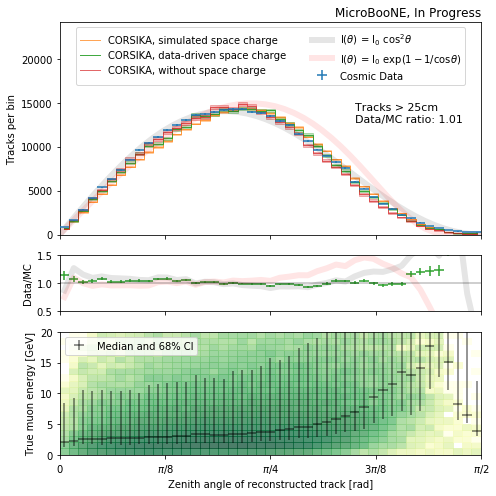

<IPython.core.display.Javascript object>

In [30]:
# We would like to make 3 plots, for the phi, length and theta angles. per bin of MC events, what is actually the mc energy of that muon
# We want only muons,
# start with the  median, maybe to the quantiles for 1sigma after
# use the ddsce sample
# field we want to use:
# track_matched_energy, pfp_length_traj, pfp_azimuth_traj, pfp_zenith_traj,

s = list_plot[0]
fig, ax = plt.subplots(
    nrows=3, sharex=True, figsize=(7, 7), gridspec_kw={"height_ratios": [3.8, 1, 2.2]}
)

data_list = mc_pfp + [data_pfp]
weights = mc_scales + [1]
data = [df.query(clean_query)[s["name"]] for df in data_list]
edges, edges_mid, bins, err, max_y = helper.histHelper(
    s["bins"], s["x_min"], s["x_max"], data, weights=weights
)

print(s["name"])

ax[0].errorbar(
    edges_mid,
    bins[-1],
    yerr=err[-1],
    xerr=edges[:-1] - edges_mid,
    fmt="none",
    c="C0",
    zorder=3,
    label=data_lab,
)
next(ax[0]._get_lines.prop_cycler)

for i, (bins_i, err_i, lab_i, max_i, alpha_i, c_i) in enumerate(
    zip(bins, err, mc_labs, max_y, mc_alpha, mc_color)
):
    if alpha_i > 0:
        ax[0].step(
            edges_mid, bins_i, lw=1, label=lab_i, where="mid", alpha=alpha_i, c=c_i
        )
        ax[0].fill_between(
            edges_mid,
            (bins_i - err_i),
            (bins_i + err_i),
            alpha=0.3,
            step="mid",
            color=c_i,
        )
ax[0].plot(
    edges,
    3.65e4 * np.sin(edges) * np.cos(edges) ** 2,
    label=r"I($\theta$) = I$_0$ $\cos^2\theta$",
    lw=6,
    alpha=0.1,
    color="k",
)

ax[0].plot(
    edges,
    3.15e4 * np.sin(edges) * np.exp(1 - 1 / np.cos(edges)),
    label=r"I($\theta$) = I$_0$ $\exp(1-1/\cos\theta)$",
    lw=6,
    alpha=0.1,
    color="r",
)

ax[0].set_ylim(0, max(max_y) * 1.35)
ax[0].set_ylabel("Tracks per bin")
ax[0].set_xlim(s["x_min"], s["x_max"])
ax[0].legend(loc="upper center", ncol=2)

ratio = bins[-1] / (bins[mc_def])
ratio_err = np.sqrt(1 / bins[-1] + 1 / (bins[mc_def] / mc_scales[mc_def])) * ratio
ax[1].errorbar(
    edges_mid,
    ratio,
    xerr=edges[1:] - edges_mid,
    yerr=ratio_err,
    fmt="none",
    color=mc_color[mc_def],
)

ax[1].plot(
    edges_mid,
    3.15e4 * np.sin(edges_mid) * np.exp(1 - 1 / np.cos(edges_mid)) / bins[mc_def],
    lw=6,
    alpha=0.1,
    color="r",
)
ax[1].plot(
    edges_mid,
    3.65e4 * np.sin(edges_mid) * np.cos(edges_mid) ** 2 / bins[mc_def],
    lw=6,
    alpha=0.1,
    color="k",
)

ax[1].axhline(y=1, color="k", alpha=0.25)
ax[1].set_ylabel("Data/MC")
ax[1].set_ylim(0.5, 1.5)
fig.tight_layout()
text_x = s["x_min"] + (s["x_max"] - s["x_min"]) * 0.7
ax[0].set_title(ub_tag, loc="right")
ax[0].text(
    text_x,
    ax[0].get_ylim()[1] * 0.53,
    "Tracks > 25cm\n" + "Data/MC ratio: {0:.2f}".format(ratio_25cm),
    fontsize=11,
)

_, x_edges, _, _ = ax[2].hist2d(
    df_mc_muon_cross_matched_25[s["name"]],
    df_mc_muon_cross_matched_25["track_matched_energy"],
    range=((s["x_min"], s["x_max"]), (0, 20)),
    cmap="YlGn",
    bins=(s["bins"], 20),
    alpha=0.7,
    norm=colors.LogNorm(),
)
bin_col = pd.cut(df_mc_muon_cross_matched_25[s["name"]], x_edges, labels=False)
median = df_mc_muon_cross_matched_25["track_matched_energy"].groupby(bin_col).median()
q_low = (
    df_mc_muon_cross_matched_25["track_matched_energy"]
    .groupby(bin_col)
    .quantile(persig1 / 100)
)
q_high = (
    df_mc_muon_cross_matched_25["track_matched_energy"]
    .groupby(bin_col)
    .quantile(persig2 / 100)
)
median = median.reindex(range(s["bins"]), fill_value=0)
q_low = q_low.reindex(range(s["bins"]), fill_value=0)
q_high = q_high.reindex(range(s["bins"]), fill_value=0)
assert len(median) == s["bins"]
assert len(q_low) == s["bins"]
x_mids = (x_edges[1:] + x_edges[:-1]) / 2
x_widths = (x_edges[1:] - x_edges[:-1]) / 2
ax[2].errorbar(
    x_mids,
    median,
    xerr=x_widths,
    yerr=[q_low, q_high],
    fmt="none",
    color="k",
    alpha=0.55,
    label="Median and 68% CI",
)

ax[2].set_xlim(s["x_min"], s["x_max"])
ax[2].set_xlabel(s["x_label"])
ax[2].set_ylabel("True muon energy [GeV]")
ax[2].legend(loc="upper left")
if "x_labels" in s:
    ax[2].set_xticks(s["x_ticks"])
    ax[2].set_xticklabels(s["x_labels"])

fig.tight_layout()
fig.savefig(outdir + s["name"] + "_25cm_true_e.pdf")

pfp_zenith_traj
pfp_azimuth_traj
pfp_length_traj


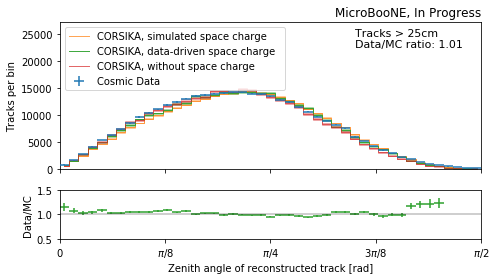

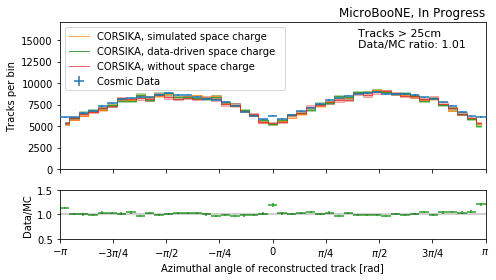

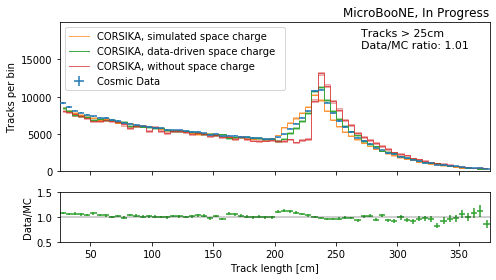

<IPython.core.display.Javascript object>

In [31]:
for s in list_plot:
    fig, ax = plt.subplots(
        nrows=2, sharex=True, figsize=(7, 4), gridspec_kw={"height_ratios": [3, 1]}
    )

    data_list = mc_pfp + [data_pfp]
    weights = mc_scales + [1]
    data = [df.query(clean_query)[s["name"]] for df in data_list]
    edges, edges_mid, bins, err, max_y = helper.histHelper(
        s["bins"], s["x_min"], s["x_max"], data, weights=weights
    )

    print(s["name"])

    ax[0].errorbar(
        edges_mid,
        bins[-1],
        yerr=err[-1],
        xerr=edges[:-1] - edges_mid,
        fmt="none",
        c="C0",
        zorder=3,
        label=data_lab,
    )
    next(ax[0]._get_lines.prop_cycler)

    for i, (bins_i, err_i, lab_i, max_i, alpha_i, c_i) in enumerate(
        zip(bins, err, mc_labs, max_y, mc_alpha, mc_color)
    ):
        if alpha_i > 0:
            ax[0].step(
                edges_mid, bins_i, lw=1, label=lab_i, where="mid", alpha=alpha_i, c=c_i
            )
            ax[0].fill_between(
                edges_mid,
                (bins_i - err_i),
                (bins_i + err_i),
                alpha=0.3,
                step="mid",
                color=c_i,
            )

    ax[0].set_ylim(0, max(max_y) * 1.52)
    ax[0].set_ylabel("Tracks per bin")
    ax[0].set_xlim(s["x_min"], s["x_max"])
    ax[0].legend(loc="upper left")
    if "x_labels" in s:
        ax[0].set_xticks(s["x_ticks"])
        ax[0].set_xticklabels(s["x_labels"])

    ratio = bins[-1] / (bins[mc_def])
    ratio_err = np.sqrt(1 / bins[-1] + 1 / (bins[mc_def] / mc_scales[mc_def])) * ratio
    ax[1].errorbar(
        edges_mid,
        ratio,
        xerr=edges[1:] - edges_mid,
        yerr=ratio_err,
        fmt="none",
        color=mc_color[mc_def],
    )

    ax[1].axhline(y=1, color="k", alpha=0.25)
    ax[1].set_xlabel(s["x_label"])
    ax[1].set_ylabel("Data/MC")
    ax[1].set_ylim(0.5, 1.5)
    text_x = s["x_min"] + (s["x_max"] - s["x_min"]) * 0.7
    ax[0].set_title(ub_tag, loc="right")
    ax[0].text(
        text_x,
        ax[0].get_ylim()[1] * 0.83,
        "Tracks > 25cm\n" + "Data/MC ratio: {0:.2f}".format(ratio_25cm),
        fontsize=11,
    )
    fig.tight_layout()
    fig.savefig(outdir + s["name"] + "_25cm.pdf")

### Verify the energy dependence using the MC samples

In [32]:
mc_pfp[mc_def].keys()

Index(['event', 'run', 'subrun', 'num_pfp', 'num_mcp', 'num_mcp_saved',
       'num_flashes', 'pdg_code', 'num_daughters', 'is_primary', 'n_hits',
       'n_clusters', 'pfp_vx', 'pfp_vy', 'pfp_vz', 'track_valid',
       'track_startx', 'track_starty', 'track_startz', 'track_endx',
       'track_endy', 'track_endz', 'track_length', 'track_hasmomentum',
       'track_startmomentumx', 'track_startmomentumy', 'track_startmomentumz',
       'track_endmomentumx', 'track_endmomentumy', 'track_endmomentumz',
       'track_theta', 'track_phi', 'track_zenith', 'track_azimuth',
       'track_mcs_momentum', 'track_mcs_mom_err', 'track_mcs_likelihood',
       'track_mcs_energy', 'track_matched_pdgcode', 'track_matched_energy',
       'track_matched_kBeamNeutrino', 'track_matched_time',
       'track_matched_process', 'track_matched_end_process',
       'track_matched_startinside', 'track_matched_endinside',
       'track_matched_partinside', 'track_matched_startx',
       'track_matched_starty', 't

<IPython.core.display.Javascript object>

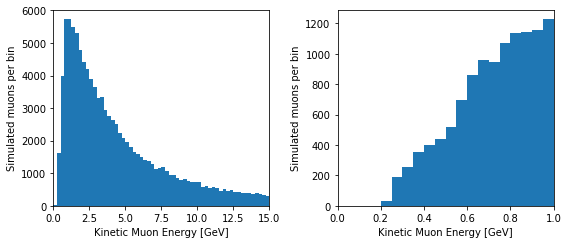

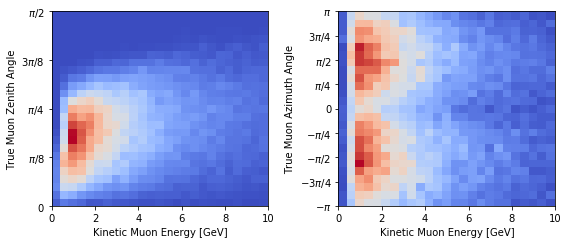

<IPython.core.display.Javascript object>

In [33]:
# Goal is to make a plot in length and agnles
# 'pfp_zenith_traj', 'pfp_azimuth_traj', 'pfp_length_traj',
# 'track_matched_time' 'track_matched_pdgcode', 'track_matched_energy'
# Energy dependence of reconstructed tracks I
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
ax[0].hist(
    df_mc_muon_cross_matched_25["track_matched_energy"] - muon_mass,
    bins=60,
    range=(0, 15),
)
ax[0].set_xlim(0, 15)
ax[1].hist(
    df_mc_muon_cross_matched_25["track_matched_energy"] - muon_mass,
    bins=20,
    range=(0, 1),
)
[a.set_xlabel("Kinetic Muon Energy [GeV]") for a in ax]
[a.set_ylabel("Simulated muons per bin") for a in ax]
ax[1].set_xlim(0, 1)
fig.tight_layout()
plt.savefig(outdir + "_e_start1d.pdf")

fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
ax[0].hist2d(
    df_mc_muon_cross_matched_25["track_matched_energy"] - muon_mass,
    df_mc_muon_cross_matched_25["mc_zenith_start"],
    range=((0, 10), (0, np.pi / 2)),
    cmap="coolwarm",
    bins=(25, 25),
)
ax[0].set_ylabel("True Muon Zenith Angle")
ax[0].set_yticks(zenith_ticks)
ax[0].set_yticklabels(zenith_labels)

ax[1].hist2d(
    df_mc_muon_cross_matched_25["track_matched_energy"] - muon_mass,
    df_mc_muon_cross_matched_25["mc_azimuth_start"],
    range=((0, 10), (-np.pi, np.pi)),
    cmap="coolwarm",
    bins=(25, 25),
)
ax[1].set_ylabel("True Muon Azimuth Angle")
ax[1].set_yticks(azimuth_ticks)
ax[1].set_yticklabels(azimuth_labels)

[a.set_xlabel("Kinetic Muon Energy [GeV]") for a in ax]

fig.tight_layout()
plt.savefig(outdir + "_e_start2d.pdf")

In [34]:
df_mc_muon_cross_matched_25["mc_azimuth_start"].describe()

count    116974.000000
mean          0.023347
std           1.782097
min          -3.141521
25%          -1.537016
50%           0.045132
75%           1.592816
max           3.141579
Name: mc_azimuth_start, dtype: float64

<IPython.core.display.Javascript object>

In [35]:
e_lims = [1, 5]
q_arr = [
    "track_matched_energy < @e_lims[0]",
    "@e_lims[0] < track_matched_energy < @e_lims[1]",
    "track_matched_energy > @e_lims[1]",
    "track_matched_energy>0",
]
e_labs = ["Below 1 GeV", "Between 1 and 5 GeV", "Above 5 GeV"]
fields = ["pfp_zenith_traj", "pfp_azimuth_traj", "pfp_length_traj"]

data_energy_split = {}
for f in fields:
    print(f)
    data_energy_split[f] = [
        df_mc_muon_cross_matched_25.query(q)[f].values for q in q_arr
    ]

pfp_zenith_traj
pfp_azimuth_traj
pfp_length_traj


<IPython.core.display.Javascript object>

pfp_zenith_traj
pfp_azimuth_traj
pfp_length_traj


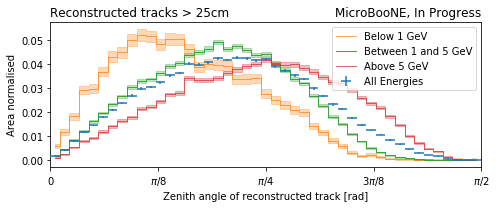

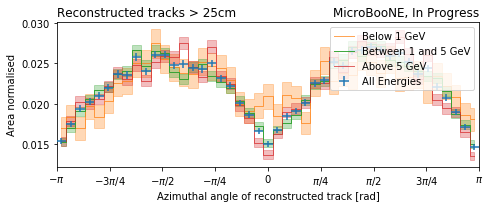

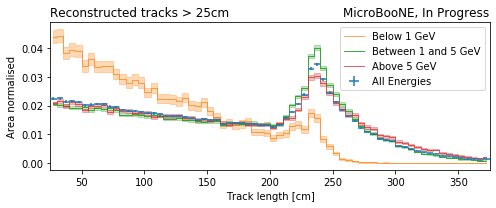

<IPython.core.display.Javascript object>

In [36]:
for s in list_plot:
    fig, ax = plt.subplots(figsize=(7, 3))
    data = data_energy_split[s["name"]]
    edges, edges_mid, bins, err, max_y = helper.histHelper(
        s["bins"], s["x_min"], s["x_max"], data
    )

    err = [e / sum(b) for e, b in zip(err, bins)]
    bins = [b / sum(b) for b in bins]
    print(s["name"])
    ax.errorbar(
        edges_mid,
        bins[-1],
        yerr=err[-1],
        xerr=edges[:-1] - edges_mid,
        fmt="none",
        c="C0",
        zorder=3,
        label="All Energies",
    )
    next(ax._get_lines.prop_cycler)

    for i, (bins_i, err_i, lab_i, max_i, alpha_i, c_i) in enumerate(
        zip(bins, err, e_labs, max_y, mc_alpha, mc_color)
    ):
        if alpha_i > 0:
            ax.step(
                edges_mid, bins_i, lw=1, label=lab_i, where="mid", alpha=alpha_i, c=c_i
            )
            ax.fill_between(
                edges_mid,
                (bins_i - err_i),
                (bins_i + err_i),
                alpha=0.3,
                step="mid",
                color=c_i,
            )
    # ax.set_ylim(0, min(ax.get_ylim()[1] * 1.6, 0.05))
    ax.set_ylabel("Area normalised")
    ax.set_xlim(s["x_min"], s["x_max"])
    ax.legend(loc="upper right")
    if "x_labels" in s:
        ax.set_xticks(s["x_ticks"])
        ax.set_xticklabels(s["x_labels"])

    text_x = s["x_min"] + (s["x_max"] - s["x_min"]) * 0.3
    ax.set_xlabel(s["x_label"])
    ax.set_title(ub_tag, loc="right")
    ax.set_title("Reconstructed tracks > 25cm", loc="left")

    fig.tight_layout()
    fig.savefig(outdir + s["name"] + "_25cm_syst.pdf")

### Track Resolution


Length
37.5 	 36.16105 	 [-4.08999206 -2.19662476 -0.14732847] 	 1.9713317909240722
62.5 	 59.54476 	 [-5.28852123 -2.37969589 -0.21343629] 	 2.5375424674034117
87.5 	 84.26442 	 [-5.65108888 -2.39767838 -0.26577636] 	 2.692656260681152
112.5 	 108.89289 	 [-5.79252505 -2.34609222 -0.32033585] 	 2.736094599533081
137.5 	 133.98505 	 [-6.30915829 -2.32218933 -0.32042893] 	 2.994364677429199
162.5 	 158.9985 	 [-6.04411908 -2.17498779 -0.28821559] 	 2.8779517433166504
187.5 	 184.45837 	 [-5.84754701 -2.11564636 -0.25192847] 	 2.797809272766113
212.5 	 212.4489 	 [-4.97105756 -0.90455627 -0.16066809] 	 2.4051947326660152
237.5 	 235.23543 	 [-3.58889362 -0.3449707   0.06809147] 	 1.8284925483703611
262.5 	 259.6521 	 [-2.85518941 -0.26135254  0.29468197] 	 1.5749356884002685
287.5 	 284.90585 	 [-2.65305606 -0.34213257  0.45673916] 	 1.5548976119995115
312.5 	 309.43774 	 [-2.78884508 -0.47465515  0.48051164] 	 1.634678357696533
337.5 	 333.45834 	 [-3.31580593 -0.56863403  0.36719626] 

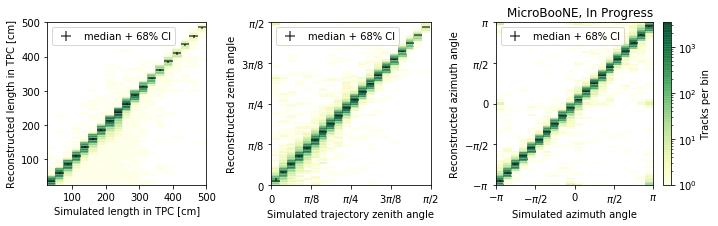

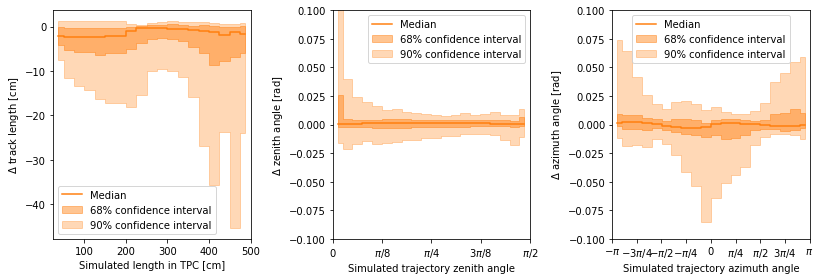

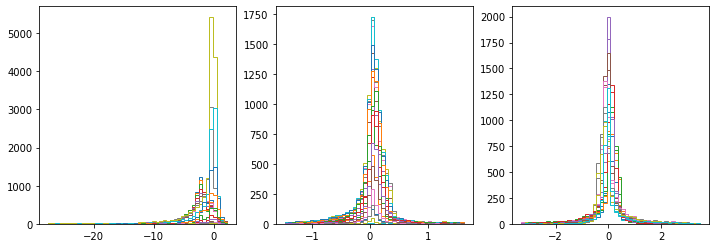

<IPython.core.display.Javascript object>

In [37]:
fig, ax = plt.subplots(
    ncols=3, figsize=(10.1, 3.25), gridspec_kw={"width_ratios": [4, 4, 4.95]}
)
fig_res, ax_res = plt.subplots(ncols=3, figsize=(11.5, 4))
fig2, ax2 = plt.subplots(ncols=3, figsize=(12, 4))
n_x = 20
n_y = 101

print("\nLength")
y_max = 500
fld_mc, fld_reco = "track_matched_length_sce", "pfp_length_traj"
h, x_edges, y_edges, im = ax[0].hist2d(
    df_resolution[fld_mc],
    df_resolution[fld_reco],
    cmap="YlGn",
    vmin=10,
    vmax=3400,
    bins=(n_x - 1, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
    range=((25, y_max), (25, y_max)),
)
ax[0].set_xlabel("Simulated length in TPC [cm]")
ax[0].set_ylabel("Reconstructed length in TPC [cm]")
mids, mean, err, quants = getResolution(
    df_resolution[fld_mc], df_resolution[fld_reco], x_edges, ax2[0]
)
ax[0].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 68% CI",
    alpha=0.7,
)
ax[0].legend(loc="upper left")

ax_res[0].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[0].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[0].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[0].set_xlabel("Simulated length in TPC [cm]")
ax_res[0].set_ylabel(r"$\Delta$ track length [cm]")
ax_res[0].set_xlim(25, y_max)
ax_res[0].legend()


print("\nZenith")
fld_mc, fld_reco = "mc_zenith_traj", "pfp_zenith_traj"
h, x_edges, y_edges, im = ax[1].hist2d(
    df_resolution[fld_mc],
    df_resolution[fld_reco],
    cmap="YlGn",
    vmin=1,
    vmax=3400,
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
)
ax[1].set_xticks(zenith_ticks)
ax[1].set_xticklabels(zenith_labels)
ax[1].set_yticks(zenith_ticks)
ax[1].set_yticklabels(zenith_labels)
ax[1].set_xlabel("Simulated trajectory zenith angle")
ax[1].set_ylabel("Reconstructed zenith angle")
ax[1].set_ylim(0, np.pi / 2)
mids, mean, err, quants = getResolution(
    df_resolution[fld_mc], df_resolution[fld_reco], x_edges, ax2[1], periodic=True
)
ax[1].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 68% CI",
    alpha=0.7,
)
ax[1].legend(loc="upper left")


ax_res[1].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[1].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[1].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[1].set_xticks(zenith_ticks)
ax_res[1].set_xticklabels(zenith_labels)
ax_res[1].set_xlabel("Simulated trajectory zenith angle")
ax_res[1].set_ylabel(r"$\Delta$ zenith angle [rad]")
ax_res[1].set_xlim(0, np.pi / 2)
ax_res[1].set_ylim(-0.1, 0.1)
ax_res[1].legend()

print("\nAzimuth")
fld_mc, fld_reco = "mc_azimuth_traj", "pfp_azimuth_traj"
h, x_edges, y_edges, im = ax[2].hist2d(
    df_resolution[fld_mc],
    df_resolution[fld_reco],
    cmap="YlGn",
    vmin=1,
    vmax=3400,
    bins=(n_x, n_y),
    alpha=0.65,
    norm=colors.LogNorm(),
)
ax[2].set_xticks(azimuth_ticks[::2])
ax[2].set_xticklabels(azimuth_labels[::2])
ax[2].set_yticks(azimuth_ticks[::2])
ax[2].set_yticklabels(azimuth_labels[::2])
ax[2].set_xlabel("Simulated azimuth angle")
ax[2].set_ylabel("Reconstructed azimuth angle")
ax[2].set_ylim(-np.pi, np.pi)
mids, mean, err, quants = getResolution(
    df_resolution[fld_mc], df_resolution[fld_reco], x_edges, ax2[2], periodic=True
)
ax[2].errorbar(
    mids,
    mean,
    xerr=(mids[0] - x_edges[0]),
    yerr=np.array(err).T,
    color="k",
    fmt="none",
    label=r"median + 68% CI",
    alpha=0.7,
)
ax[2].legend(loc="upper left")
ax[2].set_title(ub_tag, loc="right")

ax_res[2].step(mids, quants[2], lw=1.5, label="Median", where="mid", color="C1")
ax_res[2].fill_between(
    mids,
    quants[1],
    quants[3],
    alpha=0.45,
    step="mid",
    color="C1",
    label="68% confidence interval",
)
ax_res[2].fill_between(
    mids,
    quants[0],
    quants[4],
    alpha=0.3,
    step="mid",
    color="C1",
    label="90% confidence interval",
)
ax_res[2].set_xticks(azimuth_ticks)
ax_res[2].set_xticklabels(azimuth_labels)
ax_res[2].set_xlabel("Simulated trajectory azimuth angle")
ax_res[2].set_ylabel(r"$\Delta$ azimuth angle [rad]")
ax_res[2].set_xlim(-np.pi, np.pi)
ax_res[2].set_ylim(-0.1, 0.1)
ax_res[2].legend(loc="upper center")

clb = fig.colorbar(im, ax=ax[2])
clb.set_label("Tracks per bin", rotation=90)
fig.tight_layout()
fig_res.tight_layout()
fig.savefig(outdir + "resolution_25cm.pdf")
fig_res.savefig(outdir + "resolution_25cm_errors.pdf")
fig2.savefig(outdir + "resolution_shapes_25cm.pdf")

137.5 	 133.98505 	 [-16.39632797  -6.30915829  -2.32218933  -0.32042893   1.28742523] 	 2.994364677429199


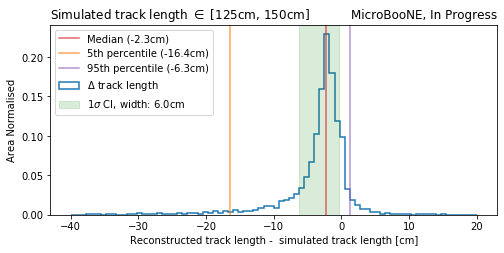

<IPython.core.display.Javascript object>

In [38]:
## make the one plot that will describe the resolution:
def getResolution2(data_x, data_y, x_edges, bin_i, periodic=False):
    mean = []
    err = []
    mids = 0.5 * (x_edges[1:] + x_edges[:-1])
    bin_id = np.digitize(data_x, x_edges)
    data_diff = data_y - data_x
    if periodic:
        data_diff = (data_diff + np.pi) % (2 * np.pi) - np.pi
        data_diff *= 180 / np.pi
        mids *= 180 / np.pi

    percentiles = np.percentile(
        data_diff[bin_id == bin_i], [per1, persig1, 50, persig2, per2]
    )
    print(
        round(mids[bin_i - 1] * 10) / 10,
        "\t",
        np.median(data_y[bin_id == bin_i]),
        "\t",
        percentiles,
        "\t",
        (percentiles[3] - percentiles[1]) / 2,
    )
    if periodic:
        percentiles /= 180 / np.pi
        mean = mids[bin_i - 1] / (180 / np.pi) + percentiles[2]
    else:
        mean = mids[bin_i - 1] + percentiles[2]
    err = percentiles

    if periodic:
        mids /= 180 / np.pi
    return mids[bin_i - 1], percentiles[2], err, data_diff[bin_id == bin_i]


n_x = 20
n_y = 101
y_max = 500
fld_mc, fld_reco = "track_matched_length_sce", "pfp_length_traj"
h, x_edges, y_edges = np.histogram2d(
    df_resolution[fld_mc],
    df_resolution[fld_reco],
    range=((25, y_max), (25, y_max)),
    bins=(n_x - 1, n_y),
)
mids, mean, err, projection = getResolution2(
    df_resolution[fld_mc], df_resolution[fld_reco], x_edges, 5
)

fig, ax = plt.subplots(figsize=(8, 3.5))
ax.hist(
    projection,
    bins=80,
    range=(-40, 20),
    histtype="step",
    density=1,
    lw=1.5,
    label=r"$\Delta$ track length",
)
ax.axvline(x=mean, label="Median ({0:.1f}cm)".format(mean), c="C3", alpha=0.7)
ax.axvline(
    x=err[0], label="5th percentile ({0:.1f}cm)".format(err[0]), c="C1", alpha=0.7
)
ax.axvspan(
    xmin=err[1],
    xmax=err[3],
    alpha=0.15,
    color="g",
    label=r"1$\sigma$ CI, width: {0:0.1f}cm".format(err[3] - err[1]),
)
ax.axvline(
    x=err[-1], label="95th percentile ({0:.1f}cm)".format(err[1]), c="C4", alpha=0.7
)
ax.legend()
ax.set_xlabel("Reconstructed track length -  simulated track length [cm]")
ax.set_ylabel("Area Normalised")
ax.set_title(ub_tag, loc="right")
ax.set_title(r"Simulated track length $\in$ [125cm, 150cm]", loc="left")
fig.savefig(outdir + "resolution_125cm_exp.pdf")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


1193.1790268456357
2160.888324873088


No handles with labels found to put in legend.


1949.0


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


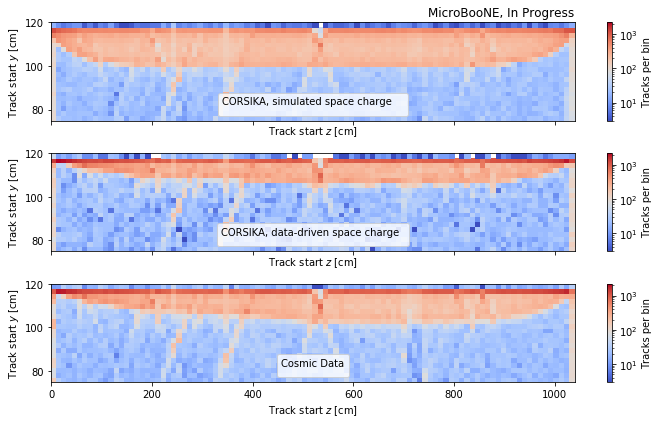

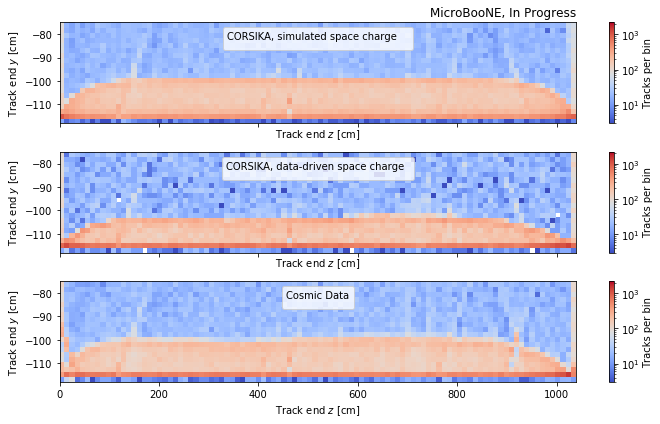

<IPython.core.display.Javascript object>

In [39]:
## 2D plot of the YZ boundary to look at the start point!
# mc_keys= ['sce', 'ddsce', 'nosce', 'cmc']
mc_index = slice(0, 2)
data_list = mc_pfp[mc_index] + [data_pfp]
weights = mc_scales[mc_index] + [1]
labels = mc_labs[mc_index] + [data_lab]
n_bins = (100, 20)


fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(10, 6))
yzrange = ((0, 1040), (75, 120))

for ax_i, df_i, scale_i, lab_i in zip(ax, data_list, weights, labels):
    w_i = [scale_i] * len(df_i)
    h, x_edges, y_edges, im = ax_i.hist2d(
        df_i["track_startz"],
        df_i["track_starty"],
        weights=w_i,
        cmap="coolwarm",
        bins=n_bins,
        vmax=2200,
        vmin=3,
        range=yzrange,
        norm=colors.LogNorm(),
    )
    clb = fig.colorbar(im, ax=ax_i, label="Tracks per bin")
    ax_i.legend(loc="lower center", title=lab_i)
    ax_i.set_xlabel(r"Track start $z$ [cm]")
    ax_i.set_ylabel(r"Track start $y$ [cm]")
    print(np.amax(h))

ax[0].set_title(ub_tag, loc="right")
fig.tight_layout()
fig.savefig(outdir + "2d_track_start.pdf", bbox_inches="tight")

###########################

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(10, 6))
yzrange = ((0, 1040), (-118, -75))

for ax_i, df_i, scale_i, lab_i in zip(ax, data_list, weights, labels):
    w_i = [scale_i] * len(df_i)
    h, x_edges, y_edges, im = ax_i.hist2d(
        df_i["track_endz"],
        df_i["track_endy"],
        weights=w_i,
        cmap="coolwarm",
        bins=n_bins,
        vmax=2200,
        vmin=3,
        range=yzrange,
        norm=colors.LogNorm(),
    )
    clb = fig.colorbar(im, ax=ax_i, label="Tracks per bin")
    ax_i.legend(loc="upper center", title=lab_i)
    ax_i.set_xlabel(r"Track end $z$ [cm]")
    ax_i.set_ylabel(r"Track end $y$ [cm]")

ax[0].set_title(ub_tag, loc="right")
fig.tight_layout()
fig.savefig(outdir + "2d_track_end.pdf", bbox_inches="tight")

In [48]:
# purity, ratio in function of track length

ratio = []
purity = []
p_err = []
r_err = []

lengths = np.linspace(5, 175, 35)

for df, lab, scale in zip(mc_pfp, mc_labs, mc_scales):
    df_view = df.query(muon_matched_query)
    ratio_i = []
    purity_i = []
    p_err_i = []
    r_err_i = []
    print("\n" + lab)
    for l in lengths:
        df_view2 = df_view.query("pfp_length_traj>@l")
        df_view3 = df.query("(pfp_length_traj>@l)")
        broken_pure_bool = ~df_view2.duplicated(
            subset=["track_matched_time", "track_matched_energy"], keep=False
        )
        denom = len(df_view3)
        nom = len(data_pfp.query("pfp_length_traj>@l"))
        r = nom / denom / scale
        print(
            "length cut: {0:.2f} \t purtiy: {1:.2f}% \t data/MC: {2:.3f}".format(
                l, sum(broken_pure_bool) / denom * 100, r
            )
        )
        purity_i.append(sum(broken_pure_bool) / denom)
        ratio_i.append(r)
        # print(scale, nom,denom,np.sqrt(1/nom+1/(denom/scale))*r)
        r_err_i.append(np.sqrt(1 / nom + scale / denom) * r)
    ratio.append(ratio_i)
    purity.append(purity_i)
    r_err.append(r_err_i)


CORSIKA, simulated space charge    
length cut: 5.00 	 purtiy: 85.42% 	 data/MC: 1.051
length cut: 10.00 	 purtiy: 92.70% 	 data/MC: 1.035
length cut: 15.00 	 purtiy: 95.63% 	 data/MC: 1.028
length cut: 20.00 	 purtiy: 97.02% 	 data/MC: 1.024
length cut: 25.00 	 purtiy: 97.71% 	 data/MC: 1.021
length cut: 30.00 	 purtiy: 98.11% 	 data/MC: 1.020
length cut: 35.00 	 purtiy: 98.40% 	 data/MC: 1.019
length cut: 40.00 	 purtiy: 98.61% 	 data/MC: 1.018
length cut: 45.00 	 purtiy: 98.76% 	 data/MC: 1.018
length cut: 50.00 	 purtiy: 98.90% 	 data/MC: 1.018
length cut: 55.00 	 purtiy: 99.01% 	 data/MC: 1.017
length cut: 60.00 	 purtiy: 99.11% 	 data/MC: 1.017
length cut: 65.00 	 purtiy: 99.20% 	 data/MC: 1.016
length cut: 70.00 	 purtiy: 99.29% 	 data/MC: 1.016
length cut: 75.00 	 purtiy: 99.35% 	 data/MC: 1.016
length cut: 80.00 	 purtiy: 99.40% 	 data/MC: 1.017
length cut: 85.00 	 purtiy: 99.45% 	 data/MC: 1.017
length cut: 90.00 	 purtiy: 99.49% 	 data/MC: 1.017
length cut: 95.00 	 purtiy: 

length cut: 70.00 	 purtiy: 99.32% 	 data/MC: 0.992
length cut: 75.00 	 purtiy: 99.40% 	 data/MC: 0.992
length cut: 80.00 	 purtiy: 99.45% 	 data/MC: 0.991
length cut: 85.00 	 purtiy: 99.50% 	 data/MC: 0.991
length cut: 90.00 	 purtiy: 99.54% 	 data/MC: 0.991
length cut: 95.00 	 purtiy: 99.58% 	 data/MC: 0.992
length cut: 100.00 	 purtiy: 99.62% 	 data/MC: 0.991
length cut: 105.00 	 purtiy: 99.67% 	 data/MC: 0.992
length cut: 110.00 	 purtiy: 99.70% 	 data/MC: 0.992
length cut: 115.00 	 purtiy: 99.72% 	 data/MC: 0.993
length cut: 120.00 	 purtiy: 99.75% 	 data/MC: 0.993
length cut: 125.00 	 purtiy: 99.77% 	 data/MC: 0.994
length cut: 130.00 	 purtiy: 99.78% 	 data/MC: 0.994
length cut: 135.00 	 purtiy: 99.80% 	 data/MC: 0.993
length cut: 140.00 	 purtiy: 99.82% 	 data/MC: 0.994
length cut: 145.00 	 purtiy: 99.83% 	 data/MC: 0.994
length cut: 150.00 	 purtiy: 99.85% 	 data/MC: 0.994
length cut: 155.00 	 purtiy: 99.86% 	 data/MC: 0.993
length cut: 160.00 	 purtiy: 99.86% 	 data/MC: 0.995

<IPython.core.display.Javascript object>

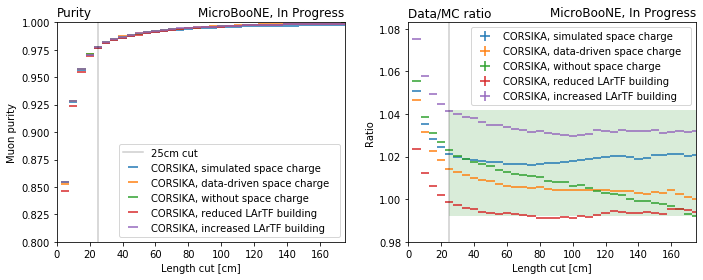

<IPython.core.display.Javascript object>

In [49]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(10, 4))

idx = [0, 1, 2, 4, 5]
for p, r, lab, r_err in zip(
    np.array(purity)[idx],
    np.array(ratio)[idx],
    np.array(mc_labs)[idx],
    np.array(r_err)[idx],
):
    ax[0].errorbar(
        lengths, p, xerr=(lengths[1] - lengths[0]) / 2, fmt="none", label=lab
    )
    ax[1].errorbar(
        lengths, r, xerr=(lengths[1] - lengths[0]) / 2, yerr=0, fmt="none", label=lab
    )

ax[0].axvline(x=25, alpha=0.2, color="k", label="25cm cut")
ax[0].set_ylim(0.8, 1)
ax[0].set_ylabel("Muon purity")
ax[0].set_title("Purity", loc="left")
ax[0].set_title(ub_tag, loc="right")
ax[0].set_xlabel("Length cut [cm]")
ax[1].set_ylim(0.98, 1.083)
ax[1].set_title("Data/MC ratio", loc="left")
ax[1].set_ylabel("Ratio")
ax[1].set_title(ub_tag, loc="right")
ax[1].set_xlabel("Length cut [cm]")
ax[1].legend()
ax[0].legend(loc="lower right")

ax[1].axvline(x=25, alpha=0.2, color="k", label="none")

rect = patches.Rectangle((25, 0.992), 150, 0.05, facecolor="green", alpha=0.15)
ax[1].add_patch(rect)
ax[1].set_xlim(0, 175)
ax[0].set_xlim(0, 175)

fig.tight_layout()
fig.savefig(outdir + "syst_length.pdf", bbox_inches="tight")

In [42]:
err

array([-16.39632797,  -6.30915829,  -2.32218933,  -0.32042893,
         1.28742523])

<IPython.core.display.Javascript object>

In [43]:
# calculate muon flux:
start, start_err = 127.7, 0.2
tpc, tpc_err = 111.6, 0.3
ratio, ratio_err = ratio_25cm, ratio_25cm_err
# ratio, ratio_err = 0.9626, 0.0061

err = np.sqrt((start_err / start) ** 2 + (ratio_err / ratio) ** 2) * (ratio * start)
print("Extrtapolated rate at 18m: {0:.1f}+-{1:.1f}".format(ratio * start, err))
err = np.sqrt((tpc_err / tpc) ** 2 + (ratio_err / ratio) ** 2) * (ratio * tpc)
print("Extrtapolated rate at TPC: {0:.1f}+-{1:.1f}".format(ratio * tpc, err))

Extrtapolated rate at 18m: 129.5+-0.5
Extrtapolated rate at TPC: 113.2+-0.5


<IPython.core.display.Javascript object>

## Data Run1 vs Run3

In [44]:
df_run1 = data_pfp

data_run3 = uproot.open(file_name_data3)[main_tree_name]
nentries_run3 = data_run3["Event"].numentries
df_run3 = data_run3["PFParticles"].pandas.df()

# Add the reco zenith/azimuth angles fro reco particles based on the trajectory
cols = [
    "track_startx",
    "track_starty",
    "track_startz",
    "track_endx",
    "track_endy",
    "track_endz",
]
df_run3[["pfp_zenith_traj", "pfp_azimuth_traj"]] = cosmic_angles_start_end(
    *df_run3[cols].T.values
)
df_run3["pfp_length_traj"] = straight_length(*df_run3[cols].T.values)

nom = df_run3.eval(clean_query).sum()
denom = df_run1.eval(clean_query).sum()
scale = data_n / nentries_run3
ratio_25cm = nom / denom * (scale)
ratio_25cm_err = np.sqrt(1 / nom + 1 / (denom / scale)) * ratio_25cm
print(ratio_25cm, "+/-", ratio_25cm_err)

0.9706733458190286 +/- 0.001596527407641966


<IPython.core.display.Javascript object>

In [45]:
print(data_n)
print(nentries_run3)
print(scale)

22405
49041
0.4568626251503844


<IPython.core.display.Javascript object>

pfp_zenith_traj
pfp_azimuth_traj
pfp_length_traj


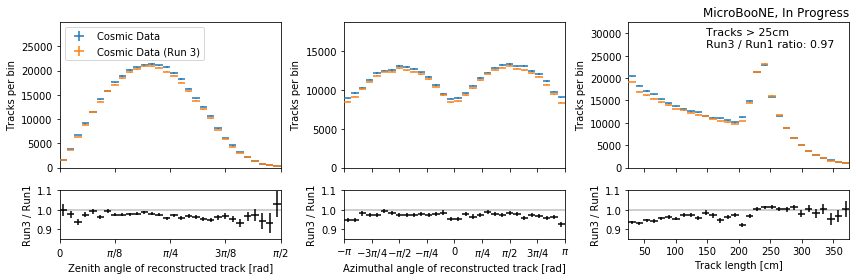

<IPython.core.display.Javascript object>

In [46]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    sharex="col",
    figsize=(12, 4),
    gridspec_kw={"height_ratios": [3, 1]},
)

for i, s in enumerate(list_plot):

    data_list = [df_run1, df_run3]
    weights = [1, data_n / nentries_run3]
    data = [df.query(clean_query)[s["name"]] for df in data_list]
    edges, edges_mid, bins, err, max_y = helper.histHelper(
        30, s["x_min"], s["x_max"], data, weights=weights
    )

    print(s["name"])

    ax[0][i].errorbar(
        edges_mid,
        bins[0],
        yerr=err[0],
        xerr=edges[:-1] - edges_mid,
        fmt="none",
        c="C0",
        zorder=3,
        label=data_lab,
    )
    ax[0][i].errorbar(
        edges_mid,
        bins[1],
        yerr=err[1],
        xerr=edges[:-1] - edges_mid,
        fmt="none",
        c="C1",
        zorder=3,
        label="Cosmic Data (Run 3)",
    )

    ax[0][i].set_ylim(0, max(max_y) * 1.4)
    ax[0][i].set_ylabel("Tracks per bin")
    ax[0][i].set_xlim(s["x_min"], s["x_max"])
    if "x_labels" in s:
        ax[0][i].set_xticks(s["x_ticks"])
        ax[0][i].set_xticklabels(s["x_labels"])

    ratio = bins[1] / (bins[0])
    ratio_err = np.sqrt(1 / bins[0] + 1 / (bins[1] / weights[1])) * ratio
    ax[1][i].errorbar(
        edges_mid,
        ratio,
        xerr=edges[1:] - edges_mid,
        yerr=ratio_err,
        fmt="none",
        color="k",
    )

    ax[1][i].axhline(y=1, color="k", alpha=0.25)
    ax[1][i].set_xlabel(s["x_label"])
    ax[1][i].set_ylabel("Run3 / Run1")
    ax[1][i].set_ylim(0.85, 1.1)

    if i == 2:
        text_x = s["x_min"] + (s["x_max"] - s["x_min"]) * 0.35
        ax[0][i].set_title(ub_tag, loc="right")
        ax[0][i].text(
            text_x,
            ax[0][i].get_ylim()[1] * 0.83,
            "Tracks > 25cm\n" + "Run3 / Run1 ratio: {0:.2f}".format(ratio_25cm),
            fontsize=11,
        )
    if i == 0:
        ax[0][i].legend(loc="upper left")

fig.tight_layout()
fig.savefig(outdir + "run1_vs_3_25cm.pdf")